In [2]:
import numpy as np
import torch
from torch import optim
from pepinillo.dataloader import POVMData
from pepinillo.operators import Pauli4, Pauli
import _pickle as pkl


In [ ]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F


class RNN(nn.Module):
    def __init__(self, hidden_size, n_outcomes, steps, num_gru_layers=2, loss_by_step=True, batchSize=None, device=None):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_gru_layers
        self.steps = steps
        self.n_outcomes = n_outcomes
        self.loss_by_step = loss_by_step
        self.device = device

        if batchSize is None:
            raise ValueError

        self.batchSize = batchSize

        
        self.rnn = nn.GRU(n_outcomes, hidden_size, num_layers=self.num_layers, dropout=0.01)
        self.outcome = nn.Linear(hidden_size, n_outcomes)
        #self.outcome2 = nn.Linear(hidden_size // 2, n_outcomes)
        self.CE = nn.CrossEntropyLoss()
        
        
    
    def initHidden(self):
        
        '''
        must be shape 
        [self.num_layers * num_directions (1 in this case), batchSize, hidden_size]
        '''
        return torch.zeros(1*self.num_layers, self.batchSize, self.hidden_size).to(self.device).double()
    
    def initX(self):
        '''
        must be shape 
        [(1 step), batchSize, hidden_size]
        '''
        return torch.zeros(1, self.batchSize, self.n_outcomes).to(self.device).double()
    

    def step(self, input, hidden):
        
        output, hidden = self.rnn(input, hidden)
        for_prediction = output.squeeze(0).to(self.device)
        outcome_prob = F.softmax(self.outcome(for_prediction), dim = 1)
        return output, hidden, outcome_prob

    
    def forward(self, inputs, hidden=None,  steps=50):
        
        '''
        must be shape
        input: [length_sequence (n_qubits), batchSize, num_features (n_outcomes)]
        hidden: [num_layers * num_directions, batchSize, hidden_size]'''
        
        if steps == 0: steps = len(inputs)
        outputs = torch.ones(steps, self.batchSize, self.hidden_size).double().to(self.device)
        outcome_probs = torch.ones(steps, self.batchSize, self.n_outcomes).double().to(self.device)
        #losses = torch.tensor(1).double().to(self.device)
        losses = torch.zeros(steps, self.batchSize)

        for i in range(steps):
            if  i == 0:
                hidden = self.initHidden()
                input = self.initX()
                inputX = input
                targets = torch.argmax(inputs[i],dim=1)
                
            else:
                input = inputs[i-1,:,:].unsqueeze(0)
                targets = torch.argmax(inputs[i],dim=1)
                

                
            output, hidden, outcome = self.step(input, hidden)

            if self.loss_by_step == True:
                #loss_i = self.CE(outcome, targets.long())
                #loss_i = self.step_loss(targets, outcome)
                loss_i = self.myCrossEntropyLoss(outcome, targets)
                losses[i,:] = loss_i
            outputs[i] = output
            outcome_probs[i] = outcome
            
        if self.loss_by_step == False:
            losses = self.loss_overall(inputs, outcome_probs)
            
        loss = torch.sum(losses)
        return outputs, hidden, outcome_probs, loss, inputX
       

    def myCrossEntropyLoss(self, outputs, labels):
        batch_size = outputs.size()[0]            # batch_size
        outputs = torch.log(outputs)   # compute the log of softmax values
        outputs = outputs[range(batch_size), labels] # pick the values corresponding to the labels
        #print(outputs.shape)
        return -torch.sum(outputs)/batch_size
    
    
    def sample(self):
    
        #initialize hidden as in model
        hidden = self.initHidden()
        inputX = self.initX()
        
        # one hot encoded for each qubit
        samples = torch.zeros(self.steps, self.batchSize, self.n_outcomes)
        probs = torch.zeros(self.batchSize)

        #go through all qubits
        for i in range(self.steps):

            #initialize for one-hot encoding, qubit_i_samples will be a class chosen for each batch entry based on probabilities
            # batchSize number of samples for ith qubit
            qubit_i_samples = torch.zeros(self.batchSize)
            if i == 0:
                output, hidden, outcome = self.step(inputX, hidden)
                qubit_i_probs = outcome.to('cpu').data.numpy()
            elif i > 0:
                output, hidden, outcome = self.step(input.unsqueeze(0).to(self.device).double(), hidden)
                qubit_i_probs = outcome.to('cpu').data.numpy()

            for batch_entry in range(self.batchSize):

                qubit_i_samples[batch_entry] = torch.from_numpy(np.random.choice([0,1,2,3], size = 1, p=qubit_i_probs[batch_entry]))

            #make the one-hot samples, use to feed as next input
            samples[i][torch.arange(qubit_i_samples.shape[0]).long(), qubit_i_samples.long()] = 1
            input = samples[i]

        return samples
    
    
    
    
    def step_loss(self, real_outcomes, predicted_outcomes, ce = True):
    
        if ce is True:
            loss = F.cross_entropy(predicted_outcomes, real_outcomes.long(), size_average=False)
        else:
            one_hot_Trueoutcomes = torch.zeros((real_outcomes.shape[0], real_outcomes.max()+1))
            one_hot_Trueoutcomes[torch.arange(real_outcomes.shape[0]).long(),real_outcomes.long()] = 1
            loss = F.mse_loss(one_hot_Trueoutcomes.to(self.device).double(), predicted_outcomes, size_average=False)
        return loss


In [ ]:
def compute_KL(model, real_data = reshaped_array, logPs = log_probs, num_samples = 150, num_layers = num_gru_layers):

    KL = 0
    fidelity = 0
    for batch_idx, (data) in enumerate(train_loader,):
        data = data[0].to(device).permute(1,0,2)
        
        outputs, hidden, outcome_probs, loss, inputX = model(data)
        logq_batch = (torch.sum(torch.log(torch.sum(outcome_probs * data, dim=2)), dim=0))
        KL += np.sum(logPs[(batch_idx*batchSize):(batch_idx*batchSize + batchSize)] - logq_batch.cpu().data.numpy())
        fidelity += np.sum(np.exp((1/2) * (logq_batch.cpu().data.numpy() - logPs[(batch_idx*batchSize):(batch_idx*batchSize + batchSize)] )))
        
        if batch_idx == 25:
            break
    
    KL = KL / (batchSize * batch_idx)
    
    fidelity = fidelity / (batchSize*batch_idx)
       
    return KL, fidelity



In [ ]:
device = torch.device("cuda:0" if torch.cuda.device_count() != 0 else "cpu")

n_qubits = 50
n_outcomes =4
batchSize =40
hidden_size = 100
num_gru_layers = 2
num_epochs = 2
log_interval = 50
lr = 0.0001

povm = Pauli4()
dataset = POVMData('../notebooks/data/TFIM_training_data.npz', povm)
dataset = POVMData(dataset.filename, dataset.povm_set, data=dataset.data[:50000])
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, num_workers=1)
model = RNN(hidden_size, n_outcomes, n_qubits, num_gru_layers=num_gru_layers, loss_by_step=True, batchSize=batchSize).to(device).double()
optimizer = optim.Adam(model.parameters(), lr=lr)


train_losses = []
KLs = []
fidelities = []
for epoch in range(1, num_epochs + 1):
    #train(epoch, train_losses)
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device).permute(1,0,2)#.reshape(n_qubits, batchSize, n_outcomes)

        #if batch_idx == 1:
         #   print(data[:,0])
        optimizer.zero_grad()
        outputs, hidden, outcome_probs, loss, inputX = model(data)
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            kl, fidelity = compute_KL(model)   

            KLs.append(KL)
            fidelities.append(fidelity)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data[1]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data[1]) ))
    avg_batch_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_batch_loss)

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, avg_batch_loss))


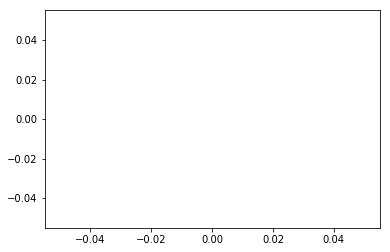

In [33]:
plt.plot(KLs)

In [31]:
samples = torch.cat([model.sample() for i in range(200)], dim=1) 
samples = samples.permute([1, 0, 2])
idsamples = np.zeros((8000, n_qubits), dtype=np.long)
idsamples2 = np.zeros((8000, n_qubits), dtype=np.long)

for i in range(8000):
    idsamples[i, :] = np.argmax(samples[i, :, :], axis=1)    
    idsamples2[i, :] = np.argmax(dataset.data[i, :, :], axis=1)
    

measure_X = [povm.rho(idsamples).measure(Pauli.X).on(i) for i in range(n_qubits)]
measure_X2 = [povm.rho(idsamples2).measure(Pauli.X).on(i) for i in range(n_qubits)]

In [23]:
np.concatenate?

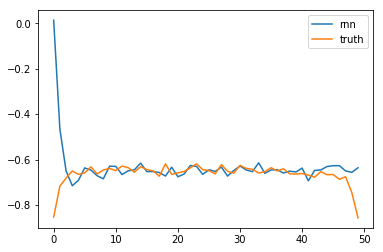

In [32]:
import matplotlib.pyplot as plt

plt.plot(measure_X, label='rnn')
plt.plot(measure_X2, label='truth')
plt.legend()